# Categorize Documents

In [3]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import string

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from nltk.corpus import wordnet as wn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

## Useful Links

### Scikit-Learn
[Scikit-Learn Documentation](http://scikit-learn.org/stable/user_guide.html)

### NLTK
[NLTK Book](http://www.nltk.org/book/)  
[NLTK API DOCS](http://www.nltk.org/api/nltk.html)  
[Module Index](http://www.nltk.org/py-modindex.html)

## Exploratory Analysis

In [4]:
df = pd.read_csv("newtrain.csv")
df_train = pd.read_csv("training.csv")
df_dev = pd.read_csv("dev_testing.csv")
df_train.head()

,Category,Text
0,5,why are yawns contagious? when people yawn
1,6,what is trans fat? how to reduce that? i heard...
2,1,roth ira vs 401k? what is the difference betwe...
3,1,how many planes fedex has? i heard that it is ...
4,3,what was the first dvd you ever bought? what w...


Looks like class labels are disproportionately represented.  
*Possible actions*: different samples methods (stratified), make up more data, etc

### Class Count

<Container object of 7 artists>

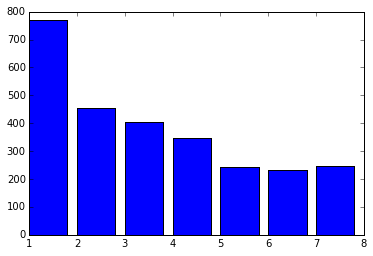

In [5]:
count_by_category = df.groupby("Category").count()
plt.bar(count_by_category.index, count_by_category["Text"])

### Text Length by Class

          Text Length
Category             
1           74.023407
2           97.407489
3           79.928571
4           94.527378
5           80.471311
6           85.396552
7           71.447154


<Container object of 7 artists>

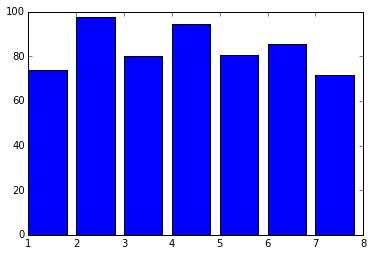

In [6]:
df["Text Length"] = list(map(len, df["Text"]))
text_len_by_category = df.groupby("Category").mean()
print(text_len_by_category)
plt.bar(text_len_by_category.index, text_len_by_category["Text Length"])

          Text Length  Avg Word Length
Category                              
1           74.023407         4.320244
2           97.407489         4.487747
3           79.928571         4.505012
4           94.527378         4.033073
5           80.471311         4.595287
6           85.396552         4.349611
7           71.447154         4.548233


<Container object of 7 artists>

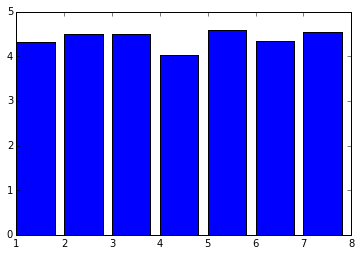

In [7]:
df["Avg Word Length"] = list(map(lambda x: np.mean(list(map(len, x.split()))), df["Text"]))
avg_word_len_by_class = df.groupby("Category").mean()
print(avg_word_len_by_class)
plt.bar(avg_word_len_by_class.index, avg_word_len_by_class["Avg Word Length"])

## Feature Extraction

### Helper Functions

In [8]:
# Figure out the best feature extraction to use: http://scikit-learn.org/stable/modules/feature_extraction.html

def to_tokens(txt):
    pattern = r'''(?x)    # set flag to allow verbose regexps
        <
        | :
        | ([A-Z]\.)+        # abbreviations, e.g. U.S.A.
       | \w+([-']\w+)*        # words with optional internal hyphens
       | \$?\d+(\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
       | \.\.\.            # ellipsis
       | [.,;"'?():-_`]+  # these are separate tokens
     '''
    return nltk.regexp_tokenize(txt, pattern)

def remove_stopwords(wrds):
    stop_words = nltk.corpus.stopwords.words('english')
    return list(filter(lambda w: w.lower() not in stop_words, wrds))

def remove_punctuation(wrds):
    exclude = list(string.punctuation) + ["--","...", "`"]
    return list(filter(lambda w: w[0] not in exclude, wrds))

def remove_digits(wrds):
    exclude = list(string.digits)
    return list(filter(lambda w: w[0] not in exclude, wrds))

### Generate Features

In [9]:
def gen_wn_features(dataset):
    wn_features = []
    for i, text in enumerate(dataset["Text"]):
        wn_features.append(to_tokens(text))
        for token in nltk.pos_tag(to_tokens(text)):
            if token[1].startswith("N"):
                s = wn.synsets(token[0].lower(), 'n')  # get its nominal synsets
                wn_features[i] += [l.name() for sns in s for l in sns.lemmas()]
                wn_features[i] += [hyp.name() for sns in s for hyp in sns.hypernyms()]
    return wn_features
        
dev_wn_features = gen_wn_features(df_dev)
df_dev["wn_features"] = dev_wn_features
train_wn_features = gen_wn_features(df_train)
df_train["wn_features"] = train_wn_features
df_wn_features = gen_wn_features(df)
df["wn_features"] = df_wn_features

In [10]:
df.head()

,Category,Text,Text Length,Avg Word Length,wn_features
0,5,why are yawns contagious? when people yawn,42,5.142857,"[why, are, yawns, contagious, ?, when, people,..."
1,6,what is trans fat? how to reduce that? i heard...,135,3.500000,"[what, is, trans, fat, ?, how, to, reduce, tha..."
2,1,roth ira vs 401k? what is the difference betwe...,108,4.190476,"[roth, ira, vs, 401k, ?, what, is, the, differ..."
3,1,how many planes fedex has? i heard that it is ...,78,3.937500,"[how, many, planes, fedex, has, ?, i, heard, t..."
4,2,what is the best photo slideshow creation appl...,107,5.750000,"[what, is, the, best, photo, slideshow, creati..."


#### TF IDF Vectorizer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=4, stop_words="english", ngram_range=(1,2), max_features=1000)
df_tfidf_features = vectorizer.fit_transform(df["Text"]).toarray()
# train_tfidf_features = vectorizer.fit_transform(df_train["Text"]).toarray()
# dev_tfidf_features = vectorizer.transform(df_dev["Text"]).toarray()

#### Count Vectorizer

In [12]:
count_vectorizer = CountVectorizer(min_df=4, stop_words="english", ngram_range=(1,2), max_features=1000)
df_count_features = count_vectorizer.fit_transform(df["Text"]).toarray()
# train_count_features = count_vectorizer.fit_transform(df_train["Text"]).toarray()
# dev_count_features = count_vectorizer.transform(df_dev["Text"]).toarray()

#### Combine Features

In [13]:
# train_features = np.hstack((train_count_features, train_tfidf_features))
# dev_features = np.hstack((dev_count_features, dev_tfidf_features))
df_features = np.hstack((df_count_features, df_tfidf_features))

## Models

### Naive Bayes

In [265]:
nb = MultinomialNB()
nb_model = nb.fit(df_features, df_train["Category"])
nb_predictions = nb_model.predict(dev_features)

accuracy_score(df_dev["Category"], nb_predictions)

ValueError: Found arrays with inconsistent numbers of samples: [1889 2698]

### SVM

In [15]:
svm = SVC()
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svm_model = GridSearchCV(svm, param_grid).fit(df_features, df["Category"])

In [16]:
print(svm_model.best_score_)
print(svm_model.best_estimator_)
print(svm_model.best_params_)

0.468124536694
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)
{'gamma': 0.001, 'kernel': 'rbf', 'C': 100}


## Prediction of the Test Set

In [17]:
df_test = pd.read_csv("newtest.csv")
test_tfidf_features = vectorizer.transform(df_test["Text"]).toarray()
test_count_features = count_vectorizer.transform(df_test["Text"]).toarray()
test_features = np.hstack((test_count_features, test_tfidf_features))
predictions = svm_model.predict(test_features)
predictions = list(zip(df_test["Id"], predictions))
predictions = pd.DataFrame(predictions)
predictions.columns = ["Id", "Category"]
predictions.to_csv("submission5.csv", index=False)